# Lecture8 SVMの例、
<div dir='rtl'>
2025.5岩政
</div>
https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

サポートベクターマシン（SVM）は、分類と回帰の両方に対応する教師付きアルゴリズムの中でも、特に強力で柔軟なクラスである。このセクションでは、サポートベクターマシンの背後にある直感と分類問題での使用方法を開発します。

まずは標準的な例から、

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

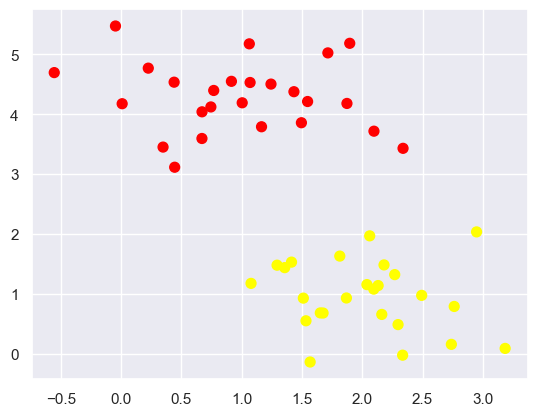

In [3]:
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

線形識別分類器は、2つのデータを分ける直線を描き、それによって分類のためのモデルを作ろうとするものです。このような2次元のデータであれば、手作業でも可能な作業である。しかし、すぐに問題が出てきます。2つのクラスを完全に区別できる分割線は1本だけではありません。

それらを以下のように描くことができる。

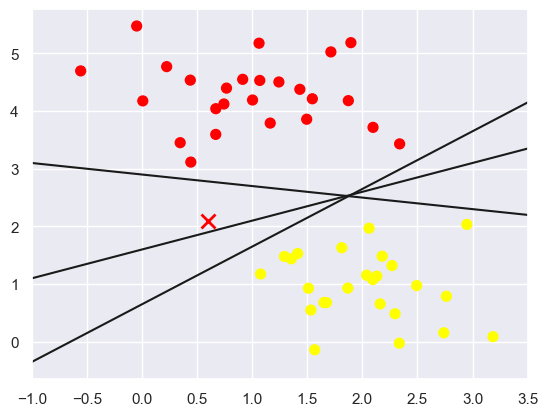

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

この3つのセパレータは非常に異なっているが、これらのサンプルを完全に識別することができる。どれを選ぶかによって、新しいデータ点（例えば、このプロットで「X」でマークされている点）には、異なるラベルが割り当てられることになります 明らかに、「クラス間に線を引く」という単純な直感だけでは不十分で、もう少し深く考える必要があります。

# Support Vector Machines: Maximizing the Margin
サポートベクターマシンは、これを改善する一つの方法です。直感的には、クラス間にゼロ幅の線を引くのではなく、各線の周囲に、ある幅のマージン（最も近い点まで）を描けばよいということです。以下は、その例である。

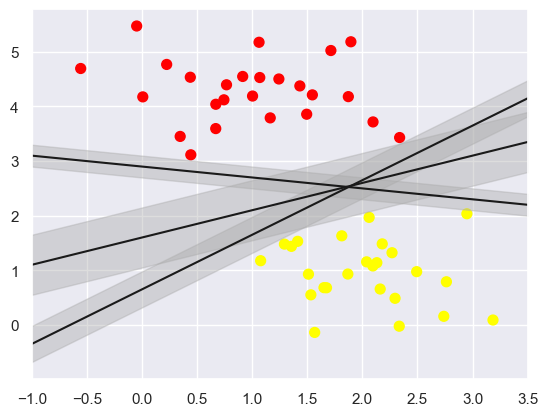

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

サポートベクターマシンでは、このマージンを最大化する直線を最適モデルとして選択することになる。サポートベクターマシンは、このような最大マージンを持つ推定器の一例である。

## Fitting a support vector machine
このデータに対して、Scikit-Learnのサポートベクトル分類器を用いて、SVMモデルを学習させます。今回は線形カーネルを使い、Cパラメータを非常に大きな値に設定します（これらの意味については後ほど詳しく説明します）。

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

ここで何が起こっているかをよりよく可視化するために、SVMの決定境界をプロットする便利な関数を作ってみましょう。

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

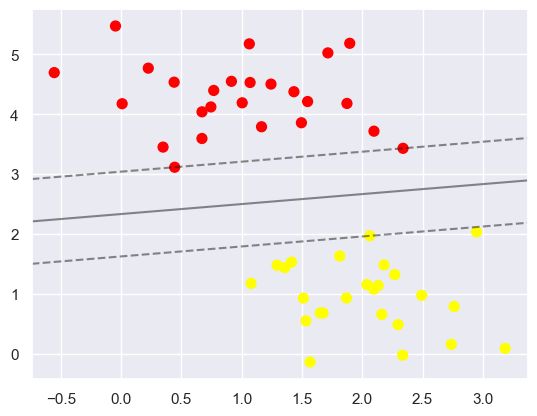

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

これは、2つのポイントセットの間のマージンを最大化する分割線である。学習点のうち数点はマージンに接していることに注目しよう。これらの点はこのフィットの重要な要素であり、サポートベクターと呼ばれ、このアルゴリズムの名前にもなっている。Scikit-Learnでは、これらの点の識別は分類器の support_vectors_ 属性に格納されます。

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

この分類器の成功の鍵は、フィットにおいてサポートベクトルの位置だけが重要であり、マージンから離れた正しい側にある点はフィットを修正しないことです。技術的には、これらの点はモデルの適合に使われる損失関数に寄与しないので、マージンを越えない限り位置と数は重要ではありません。

例えば、このデータセットの最初の60点と最初の120点から学習したモデルをプロットしてみると、このことがわかります。

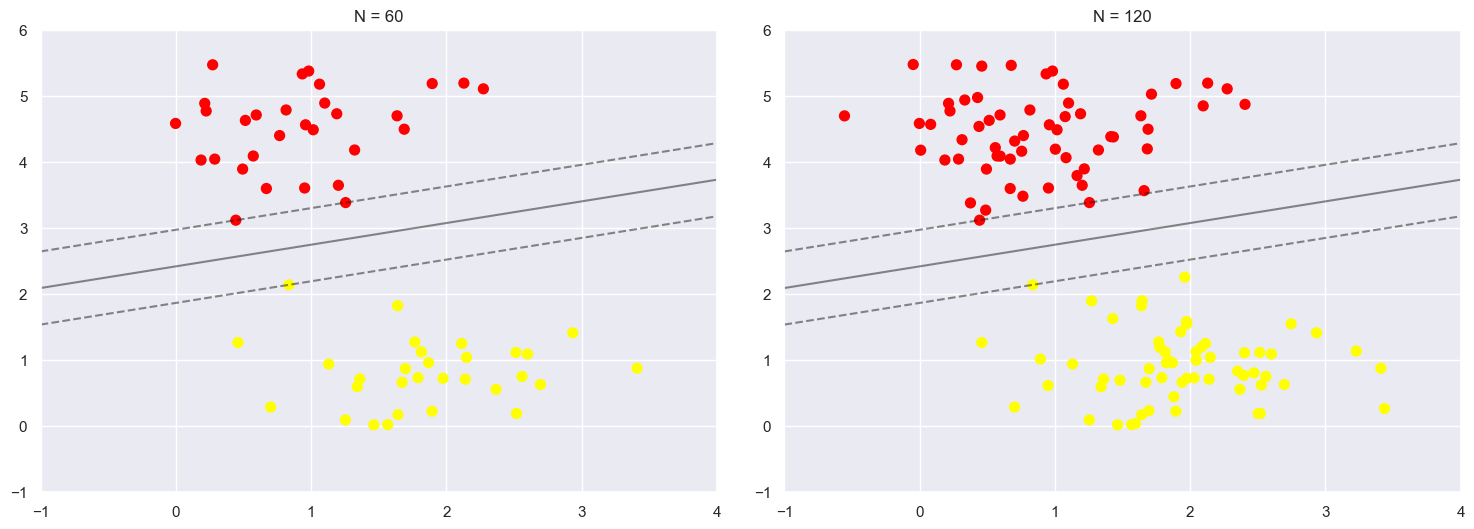

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

左の図は、60点の学習点に対するモデルとサポートベクトルである。右図では、学習点の数が2倍になっていますが、モデルは変わっていません。左図の3つのサポートベクトルは、右図のサポートベクトルのままです。このように、離れた点の正確な挙動に対して鈍感であることが、SVMモデルの強みの1つです。

もしこのノートブックをライブで実行しているなら、IPythonのインタラクティブウィジェットを使って、SVMモデルのこの特徴をインタラクティブに見ることができます。


In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## Beyond linear boundaries: Kernel SVM
SVMが非常に強力になるのは、カーネルと組み合わせた場合である。カーネルのバージョンは以前、In Depthの基底関数回帰で見たことがあります。線形回帰です。そこでは、多項式とガウス基底関数によって定義された高次元空間にデータを投影し、それによって線形分類器で非線形関係を適合させることができました。

SVMモデルでも、これと同じような考え方ができます。カーネルの必要性を説明するために、線形分離不可能なデータを見てみましょう。

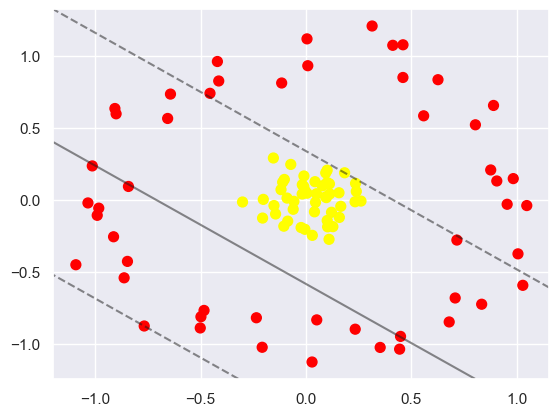

In [12]:
#from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

このデータを分離するためには、どんな線形判別もできないことは明らかです。しかし、「In Depth」の基底関数回帰から教訓を得ることができる。線形回帰の教訓を生かし、線形分離器で十分なように、データをより高い次元に投影する方法を考えましょう。例えば、1つの簡単な投影は、真ん中の塊を中心とした放射状基底関数を計算することである。


In [13]:
r = np.exp(-(X ** 2).sum(1))

もし、このノートブックをライブで使っているなら、スライダーでプロットを回転させることができます。

In [14]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

#interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
#         X=fixed(X), y=fixed(y));
interact(plot_3D, azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-30), IntSlider(value=30, descriptio…

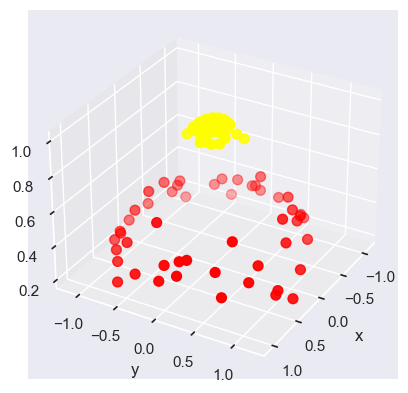

In [15]:
plot_3D(elev=30, azim=30, X=X, y=y)

## カーネル関数のパラメータによる分離の違い

In [16]:
import numpy as np
from sklearn import svm, datasets
import matplotlib.pyplot as plt
from itertools import product

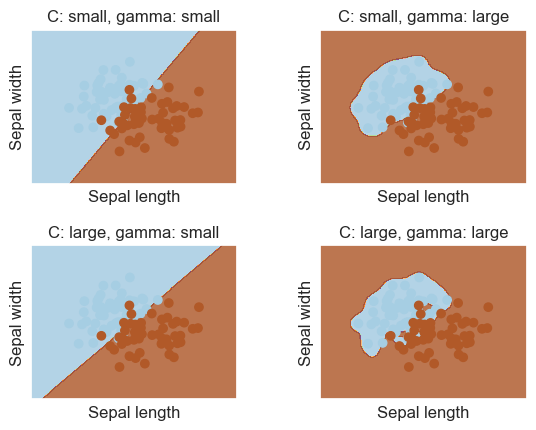

In [17]:
iris = datasets.load_iris()
#特徴量は最初の2つ, クラスラベルも最初の2つを使う
X = iris.data[:100, :2]
#特徴量にノイズを加える
E = np.random.uniform(0, 1.0, size=np.shape(X))
X += E
y = iris.target[:100]
#meshのステップサイズ
h = 0.02
#コストパラメータ
Cs = [2 ** -5, 2 ** 15]
#RBFカーネルのパラメータ
gammas = [2 ** -15, 2 ** 3]

svms = [svm.SVC(C=C, gamma=gamma).fit(X, y) for C, gamma in product(Cs, gammas)]
titles = ["C: small, gamma: small", "C: small, gamma: large",
    "C: large, gamma: small", "C: large, gamma: large"]
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for i, clf in enumerate(svms):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

横軸と縦軸はそれぞれ2つの特徴量を表しています.

Cが小さいときは決定領域の中に多くの誤分類点を含んでいる一方で, Cが大きいときは決定領域内の誤分類点が少なくなっています.
$\gamma$が小さいときの決定境界は単純な決定境界(直線)である一方で, $\gamma$が大きいときの決定境界は複雑な形をしています.